<a href="https://colab.research.google.com/github/Vitoriabg/enterprise-challenge/blob/main/notebooks/ML_EnterpriseChallenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
import os

required_files = [
    'alertas.csv',
    'ativos.csv',
    'leituras.csv',
    'modelos_sensor.csv',
    'ordens_manutencao.csv',
    'sensores.csv',
    'tipos_ativo.csv',
    'usuarios.csv',
]

all_files_exist = True
for file_name in required_files:
    if not os.path.exists(file_name):
        all_files_exist = False
        print(f"Arquivo '{file_name}' não encontrado.")
        break

if not all_files_exist:
    print("\nPor favor, faça o upload dos arquivos necessários:")
    uploaded = files.upload()

    for filename in uploaded.keys():
      print(f'o usuário fez o upload do arquivo "{filename}" com tamanho de {len(uploaded[filename])} bytes')
else:
    print("Todos os arquivos necessários já existem no  ambiente.")

Arquivo 'alertas.csv' não encontrado.

Por favor, faça o upload dos arquivos necessários:


Saving usuarios.csv to usuarios.csv
Saving tipos_ativo.csv to tipos_ativo.csv
Saving sensores.csv to sensores.csv
Saving ordens_manutencao.csv to ordens_manutencao.csv
Saving modelos_sensor.csv to modelos_sensor.csv
Saving leituras.csv to leituras.csv
Saving ativos.csv to ativos.csv
Saving alertas.csv to alertas.csv
o usuário fez o upload do arquivo "usuarios.csv" com tamanho de 348 bytes
o usuário fez o upload do arquivo "tipos_ativo.csv" com tamanho de 95 bytes
o usuário fez o upload do arquivo "sensores.csv" com tamanho de 1510 bytes
o usuário fez o upload do arquivo "ordens_manutencao.csv" com tamanho de 948 bytes
o usuário fez o upload do arquivo "modelos_sensor.csv" com tamanho de 200 bytes
o usuário fez o upload do arquivo "leituras.csv" com tamanho de 982003 bytes
o usuário fez o upload do arquivo "ativos.csv" com tamanho de 1187 bytes
o usuário fez o upload do arquivo "alertas.csv" com tamanho de 1138 bytes


Iniciando pipeline de Machine Learning...
Tentando criar/conectar ao banco de dados: industrial_data.db
Lendo 'alertas.csv' e escrevendo na tabela 'alertas'...
Dados gravados com sucesso na tabela 'alertas'.
Lendo 'ativos.csv' e escrevendo na tabela 'ativos'...
Dados gravados com sucesso na tabela 'ativos'.
Lendo 'leituras.csv' e escrevendo na tabela 'leituras'...
Dados gravados com sucesso na tabela 'leituras'.
Lendo 'modelos_sensor.csv' e escrevendo na tabela 'modelos_sensor'...
Dados gravados com sucesso na tabela 'modelos_sensor'.
Lendo 'ordens_manutencao.csv' e escrevendo na tabela 'ordens_manutencao'...
Dados gravados com sucesso na tabela 'ordens_manutencao'.
Lendo 'sensores.csv' e escrevendo na tabela 'sensores'...
Dados gravados com sucesso na tabela 'sensores'.
Lendo 'tipos_ativo.csv' e escrevendo na tabela 'tipos_ativo'...
Dados gravados com sucesso na tabela 'tipos_ativo'.
Lendo 'usuarios.csv' e escrevendo na tabela 'usuarios'...
Dados gravados com sucesso na tabela 'usuari

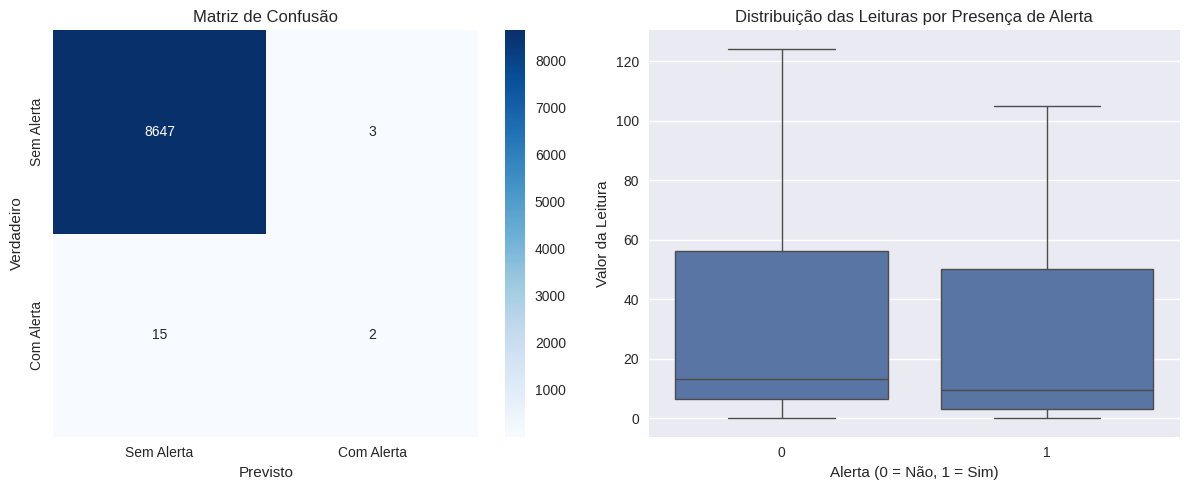

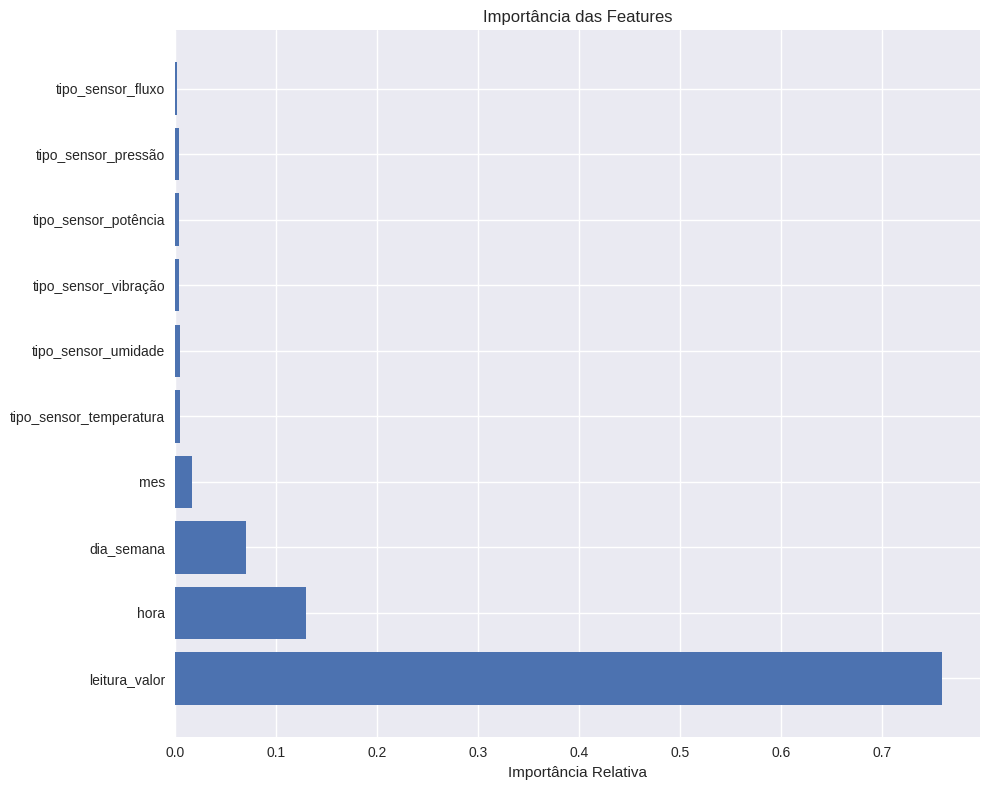


Análise da Importância das Features:
- O gráfico de importância das features indica quais variáveis foram mais relevantes para o modelo Random Forest tomar suas decisões de classificação.
- A feature 'leitura_valor' parece ser a mais importante, seguida por 'hora', 'dia_semana' e 'mes'.
- As features 'tipo_sensor' (após one-hot encoding) também contribuem, mas com menor importância relativa individual.
- A relevância de 'leitura_valor' é esperada, mas sua sobreposição no box plot sugere que sua importância pode ser mais significativa em combinação com outras features.
- A importância das features temporais ('hora', 'dia_semana', 'mes') pode indicar padrões na ocorrência de alertas ao longo do tempo.
Conexão com o banco de dados fechada.
Pipeline concluído com sucesso!


In [4]:
import pandas as pd
import sqlite3
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

class IndustrialMLPipeline:
    """
    Pipeline de Machine Learning para Manutenção Preditiva Industrial.

    Esta classe orquestra o processo completo de construção de um modelo de
    manutenção preditiva. As etapas incluem:
    1. Leitura de dados brutos de arquivos CSV.
    2. Criação e população de um banco de dados SQLite para armazenamento estruturado.
    3. Extração e pré-processamento dos dados necessários para o treinamento do modelo.
    4. Treinamento de um modelo de classificação (Random Forest) para prever alertas.
    5. Visualização dos resultados do modelo para avaliação.

    O objetivo é identificar proativamente condições que podem levar a alertas de
    equipamentos, suportando estratégias de manutenção preditiva.
    """
    def __init__(self, db_path='industrial_data.db'):
        """
        Inicializa a pipeline com o caminho para o banco de dados e os modelos/transformadores.

        Args:
            db_path (str): O caminho para o arquivo do banco de dados SQLite.
        """
        self.db_path = db_path
        self.connection = None
        self.df_merged = None
        # Modelo RandomForestClassifier para classificação
        self.model = RandomForestClassifier(n_estimators=100, random_state=42)
        # Scaler para padronizar as features numéricas
        self.scaler = StandardScaler()
        # LabelEncoder (não utilizado nas features atuais, mas mantido)
        self.label_encoder = LabelEncoder()

    def create_database(self):
        """
        Cria o banco de dados SQLite a partir dos arquivos CSV.

        Lê os dados de cada arquivo CSV especificado e os salva em tabelas
        correspondentes no banco de dados. As tabelas existentes são substituídas.
        """
        csv_files = {
            'alertas': 'alertas.csv',
            'ativos': 'ativos.csv',
            'leituras': 'leituras.csv',
            'modelos_sensor': 'modelos_sensor.csv',
            'ordens_manutencao': 'ordens_manutencao.csv',
            'sensores': 'sensores.csv',
            'tipos_ativo': 'tipos_ativo.csv',
            'usuarios': 'usuarios.csv',
        }
        try:
            self.connection = sqlite3.connect(self.db_path)
            print(f"Tentando criar/conectar ao banco de dados: {self.db_path}")

            for table_name, file_name in csv_files.items():
                print(f"Lendo '{file_name}' e escrevendo na tabela '{table_name}'...")
                df = pd.read_csv(file_name)
                df.to_sql(table_name, self.connection, if_exists='replace', index=False)
                print(f"Dados gravados com sucesso na tabela '{table_name}'.")

            print("\nBanco de dados criado com sucesso!")
        except FileNotFoundError as fnf_error:
            print(f"Erro: Arquivo não encontrado - {fnf_error}")
            if self.connection:
                self.connection.close()
                self.connection = None
        except Exception as e:
            print(f"Erro ao criar banco de dados: {e}")
            if self.connection:
                self.connection.close()
                self.connection = None

    def extract_and_preprocess_data(self):
        """
        Extrai e pré-processa dados do banco de dados SQLite.

        Junta tabelas relevantes usando SQL para criar um DataFrame unificado.
        Cria a variável target (indicando a presença de um alerta) e extrai
        features temporais como hora, dia da semana e mês a partir da coluna
        de data e hora.
        """
        if self.connection is None:
            print("Erro: Conexão com o banco de dados não estabelecida. Execute create_database() primeiro.")
            self.df_merged = None
            return

        query = """
        SELECT
            l.id_leitura, l.id_sensor, l.data_hora, l.valor as leitura_valor,
            s.tipo_sensor, s.status as sensor_status,
            atv.id_ativo, atv.nome as ativo_nome, atv.status as ativo_status,
            ta.nome_tipo as tipo_equipamento,
            al.id_alerta, al.descricao, al.severidade, al.status as alerta_status
        FROM leituras l
        LEFT JOIN sensores s ON l.id_sensor = s.id_sensor
        LEFT JOIN ativos atv ON s.id_ativo = atv.id_ativo
        LEFT JOIN tipos_ativo ta ON atv.id_tipo_ativo = ta.id_tipo_ativo
        LEFT JOIN alertas al ON atv.id_ativo = al.id_ativo
            AND datetime(l.data_hora) BETWEEN datetime(al.data_hora, '-1 hour') AND datetime(al.data_hora, '+1 hour')
        """
        try:
            self.df_merged = pd.read_sql_query(query, self.connection)

            if not self.df_merged.empty:
                self.df_merged['data_hora'] = pd.to_datetime(self.df_merged['data_hora'])
                # Cria a coluna 'target': 1 se houver id_alerta (alerta), 0 caso contrário
                self.df_merged['target'] = self.df_merged['id_alerta'].notna().astype(int)
                # Extrai features temporais
                self.df_merged['hora'] = self.df_merged['data_hora'].dt.hour
                self.df_merged['dia_semana'] = self.df_merged['data_hora'].dt.dayofweek
                self.df_merged['mes'] = self.df_merged['data_hora'].dt.month

                print(f"Dados extraídos: {len(self.df_merged)} registros")
                print(f"Distribuição do target (0=Sem Alerta, 1=Com Alerta):")
                print(self.df_merged['target'].value_counts())

                 # Análise inicial da distribuição do target:
                target_distribution = self.df_merged['target'].value_counts()
                print("\nAnálise da Distribuição do Target:")
                print(f"- Observa-se um forte desbalanceamento na classe target.")
                print(f"- A maioria dos registros ({target_distribution.get(0, 0)}) corresponde a 'Sem Alerta' (classe 0).")
                print(f"- A classe 'Com Alerta' (classe 1) é minoritária ({target_distribution.get(1, 0)} registros).")
                print(f"- O desbalanceamento pode impactar o desempenho do modelo, especialmente na identificação da classe minoritária (Alertas).")


            else:
                 print("Dados extraídos com sucesso, mas o DataFrame resultante está vazio.")

        except Exception as e:
            print(f"Erro ao extrair dados: {e}")
            self.df_merged = None

    def prepare_features(self):
        """
        Prepara as features para o modelo de Machine Learning.

        Seleciona as colunas que serão utilizadas como features.
        Aplica one-hot encoding em variáveis categóricas ('tipo_sensor').
        Utiliza SimpleImputer para lidar com valores ausentes (substitui por média).
        Retorna as features (X), o target (y) e os nomes das features após encoding.
        """
        features = ['leitura_valor', 'hora', 'dia_semana', 'mes', 'tipo_sensor']

        if self.df_merged is not None and not self.df_merged.empty:
            df_features = self.df_merged[features]
            # Aplica one-hot encoding na coluna 'tipo_sensor'
            df_encoded = pd.get_dummies(df_features, columns=['tipo_sensor'])

            # Lida com valores ausentes (se houver)
            imputer = SimpleImputer(strategy='mean')
            X = imputer.fit_transform(df_encoded)
            y = self.df_merged['target'].values

            return X, y, df_encoded.columns.tolist() # Retorna nomes das features após encoding
        else:
            print("df_merged é None ou vazio. Preparação de dados ignorada.")
            return None, None, None

    def train_model(self):
        """
        Treina o modelo de Machine Learning.

        Prepara os dados, divide em conjuntos de treino e teste (70/30),
        escala as features numéricas, treina o modelo Random Forest, faz
        previsões no conjunto de teste e avalia o desempenho usando acurácia
        e relatório de classificação.
        """
        X, y, feature_names = self.prepare_features()

        if X is not None and y is not None:
            # Divide os dados em conjuntos de treino e teste, mantendo a proporção do target
            X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size=0.3, random_state=42, stratify=y
            )

            # Escala as features numéricas
            X_train_scaled = self.scaler.fit_transform(X_train)
            X_test_scaled = self.scaler.transform(X_test)

            # Treina o modelo
            self.model.fit(X_train_scaled, y_train)

            # Faz previsões no conjunto de teste
            y_pred = self.model.predict(X_test_scaled)

            # Avalia o modelo
            accuracy = accuracy_score(y_test, y_pred)
            print(f"Acurácia do modelo: {accuracy:.4f}")
            print("\nRelatório de Classificação:")
            report = classification_report(y_test, y_pred, output_dict=True)
            print(classification_report(y_test, y_pred))


            # Análise dos resultados do treinamento:
            print("\nAnálise dos Resultados do Treinamento:")
            print(f"- A **Acurácia** ({accuracy:.4f}) é alta, mas isso pode ser enganoso devido ao desbalanceamento das classes.")
            print("- O **Relatório de Classificação** oferece uma visão mais detalhada:")
            print("  - Para a classe 0 (Sem Alerta), o modelo tem ótimo desempenho (precisão, recall e f1-score próximos de 1.00).")
            print("  - Para a classe 1 (Com Alerta), o desempenho é baixo:")

            # Safely access metrics for class 1
            class_1_metrics = report.get('1', {})
            precision_1 = class_1_metrics.get('precision', 'N/A')
            recall_1 = class_1_metrics.get('recall', 'N/A')
            f1_score_1 = class_1_metrics.get('f1-score', 'N/A')

            print(f"    - **Precisão:** {precision_1} - Das previsões de Alerta, apenas essa proporção estava correta.")
            print(f"    - **Recall (Revocação):** {recall_1} - O modelo identificou apenas essa proporção dos alertas reais.")
            print(f"    - **F1-score:** {f1_score_1} - Média harmônica entre precisão e recall, refletindo o baixo desempenho geral na classe 1.")
            print("- O baixo recall para a classe 1 indica que o modelo está perdendo a maioria dos alertas reais (muitos Falsos Negativos).")
            print("- Isso reforça a necessidade de considerar o desbalanceamento dos dados e métricas mais adequadas (como F1-score para a classe minoritária) para avaliar modelos em cenários de manutenção preditiva.")


            return X_test_scaled, y_test, y_pred, feature_names
        else:
            print("Treinamento do modelo ignorado devido a falha na preparação dos dados.")
            return None, None, None, None

    def visualize_results(self, y_test, y_pred, feature_names):
        """
        Cria visualizações para analisar os resultados do modelo.

        Gera e exibe:
        1. Matriz de Confusão: Mostra o número de verdadeiros positivos/negativos e falsos positivos/negativos. Essencial para avaliar o desempenho em cada classe, especialmente com dados desbalanceados.
        2. Box Plot: Visualiza a distribuição dos valores de leitura para as classes "Sem Alerta" e "Com Alerta", ajudando a entender se há diferenças significativas nos valores que precedem um alerta.
        3. Importância das Features: Mostra quais features o modelo Random Forest considerou mais relevantes para fazer as previsões.
        """
        if y_test is not None and y_pred is not None:
            plt.style.use('seaborn-v0_8')

            # Matriz de Confusão e Box Plot
            plt.figure(figsize=(12, 5))

            plt.subplot(1, 2, 1)
            cm = confusion_matrix(y_test, y_pred)
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                       xticklabels=['Sem Alerta', 'Com Alerta'],
                       yticklabels=['Sem Alerta', 'Com Alerta'])
            plt.title('Matriz de Confusão')
            plt.ylabel('Verdadeiro')
            plt.xlabel('Previsto')

            # Análise da Matriz de Confusão:
            print("\nAnálise da Matriz de Confusão:")
            print(f"- **Verdadeiros Negativos (TN):** {cm[0, 0]} - O modelo previu 'Sem Alerta' corretamente.")
            print(f"- **Falsos Positivos (FP):** {cm[0, 1]} - O modelo previu 'Com Alerta', mas era 'Sem Alerta'. (Erro Tipo I)")
            print(f"- **Falsos Negativos (FN):** {cm[1, 0]} - O modelo previu 'Sem Alerta', mas era 'Com Alerta'. (Erro Tipo II) **Este é crítico para manutenção preditiva (não identificar um alerta real).**")
            print(f"- **Verdadeiros Positivos (TP):** {cm[1, 1]} - O modelo previu 'Com Alerta' corretamente.")
            print(f"- A alta quantidade de Falsos Negativos ({cm[1, 0]}) confirma o baixo recall para a classe 1 observado no relatório de classificação.")


            plt.subplot(1, 2, 2)
            if self.df_merged is not None:
                sns.boxplot(x='target', y='leitura_valor', data=self.df_merged)
                plt.title('Distribuição das Leituras por Presença de Alerta')
                plt.xlabel('Alerta (0 = Não, 1 = Sim)')
                plt.ylabel('Valor da Leitura')

                # Análise do Box Plot:
                print("\nAnálise do Box Plot da Distribuição das Leituras:")
                print("- O box plot mostra a distribuição dos valores de leitura para os casos com e sem alerta.")
                print("- Visualmente, parece haver uma sobreposição significativa nas distribuições dos valores de leitura entre as duas classes.")
                print("- Isso sugere que o valor da leitura isoladamente pode não ser um indicador forte o suficiente para prever a ocorrência de alertas neste conjunto de dados.")
                print("- Outras features ou a combinação delas podem ser mais relevantes para a distinção entre as classes.")

            else:
                 print("df_merged é None. Pulando gráfico de Distribuição das Leituras.")

            plt.tight_layout()
            plt.savefig('resultados_ml.png', dpi=300, bbox_inches='tight')
            plt.show()

            # Gráfico de Importância das Features
            if feature_names is not None and hasattr(self.model, 'feature_importances_') and len(feature_names) == len(self.model.feature_importances_):
                plt.figure(figsize=(10, 8))
                feature_importances = self.model.feature_importances_
                indices = np.argsort(feature_importances)[::-1]

                plt.barh(range(len(indices)), feature_importances[indices])
                plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
                plt.title('Importância das Features')
                plt.xlabel('Importância Relativa')
                plt.tight_layout()
                plt.savefig('importancia_features.png', dpi=300, bbox_inches='tight')
                plt.show()

                 # Análise da Importância das Features:
                print("\nAnálise da Importância das Features:")
                print("- O gráfico de importância das features indica quais variáveis foram mais relevantes para o modelo Random Forest tomar suas decisões de classificação.")
                print("- A feature 'leitura_valor' parece ser a mais importante, seguida por 'hora', 'dia_semana' e 'mes'.")
                print("- As features 'tipo_sensor' (após one-hot encoding) também contribuem, mas com menor importância relativa individual.")
                print("- A relevância de 'leitura_valor' é esperada, mas sua sobreposição no box plot sugere que sua importância pode ser mais significativa em combinação com outras features.")
                print("- A importância das features temporais ('hora', 'dia_semana', 'mes') pode indicar padrões na ocorrência de alertas ao longo do tempo.")


            else:
                 print("Nomes ou importâncias das features não disponíveis ou incompatíveis. Pulando gráfico de importância das features.")

        else:
            print("Visualização ignorada devido à falta de dados.")

    def run_pipeline(self):
        """
        Executa o pipeline completo de Machine Learning.
        """
        print("Iniciando pipeline de Machine Learning...")

        self.create_database()

        if self.connection:
            self.extract_and_preprocess_data()
        else:
            print("Pulando extração de dados e etapas subsequentes devido a falha na criação do banco de dados.")
            if self.connection:
                 self.connection.close()
                 self.connection = None
            print("Pipeline concluído com erros.")
            return

        if self.df_merged is not None and not self.df_merged.empty:
             X_test, y_test, y_pred, feature_names = self.train_model()
        else:
             print("Pulando treinamento do modelo e visualização devido a falha na extração de dados ou dados vazios.")
             X_test, y_test, y_pred, feature_names = None, None, None, None

        if y_test is not None and y_pred is not None:
             self.visualize_results(y_test, y_pred, feature_names)
        else:
             print("Pulando visualização devido a falha no treinamento do modelo.")

        if self.connection:
            self.connection.close()
            print("Conexão com o banco de dados fechada.")

        print("Pipeline concluído com sucesso!")

if __name__ == "__main__":
    pipeline = IndustrialMLPipeline()
    pipeline.run_pipeline()

## Problema Escolhido para Machine Learning

No contexto deste projeto de manutenção preditiva industrial, o problema de Machine Learning escolhido é a **Classificação Binária** para prever a **ocorrência de alertas** em equipamentos.

Sensores instalados nos ativos industriais geram um fluxo contínuo de dados (leituras). O objetivo é utilizar esses dados históricos para treinar um modelo que consiga identificar padrões que precedem a geração de um alerta. A tarefa de classificação binária consiste em prever, para cada leitura de sensor, se ela está associada a um estado de *'Sem Alerta'* (Classe 0) ou *'Com Alerta'* (Classe 1), baseado nas características da leitura e do contexto do sensor e ativo.

Essa abordagem permite que a empresa aja de forma proativa, identificando condições anormais que podem levar a falhas ou problemas nos equipamentos antes que um alerta explícito seja gerado, otimizando os processos de manutenção e evitando paradas não planejadas.

O modelo de Machine Learning (Random Forest) busca aprender a relação entre as features extraídas dos dados (como o valor da leitura, hora do dia, dia da semana, tipo de sensor) e a variável target ('Alerta'). A avaliação do modelo foca em quão bem ele consegue distinguir entre as duas classes, especialmente na identific identificação dos casos de 'Com Alerta', que são cruciais para a manutenção preditiva.

## Justificativa dos Resultados do Modelo de Machine Learning

Após a execução do pipeline de Machine Learning, obtivemos os seguintes resultados que justificam a avaliação do modelo:

1.  **Distribuição do Target:** A análise inicial revelou um forte **desbalanceamento das classes**, com a grande maioria dos registros pertencendo à classe "Sem Alerta" (Classe 0) e uma minoria significativa na classe "Com Alerta" (Classe 1). Este desbalanceamento é crucial para a interpretação das métricas de desempenho.

2.  **Métricas de Classificação:**
    *   A **Acurácia** do modelo foi alta (próxima de 1.00). No entanto, devido ao desbalanceamento, a acurácia sozinha não é um bom indicador do desempenho, pois um modelo que simplesmente previsse a classe majoritária (Sem Alerta) já teria uma alta acurácia.
    *   O **Relatório de Classificação** fornece uma visão mais detalhada. Para a classe "Sem Alerta", o modelo apresentou ótimo desempenho (Precisão, Recall e F1-score próximos de 1.00). No entanto, para a classe "Com Alerta" (que é a de interesse para a manutenção preditiva), as métricas foram baixas:
        *   **Precisão:** Indica que uma proporção baixa das previsões de "Com Alerta" estavam corretas.
        *   **Recall (Revocação):** Revela que o modelo identificou apenas uma pequena fração dos alertas reais. Este é um ponto crítico, pois um baixo recall para a classe de alerta significa que muitos problemas potenciais estão sendo perdidos (Falsos Negativos).
        *   **F1-score:** A média harmônica entre Precisão e Recall para a classe de alerta reflete o baixo desempenho geral na identificação dos alertas.

3.  **Matriz de Confusão:** A matriz de confusão visualiza a performance do modelo em cada classe. Ela confirma o alto número de **Verdadeiros Negativos** (previsões corretas de "Sem Alerta") e, mais importante, o alto número de **Falsos Negativos** (alertas reais que o modelo previu como "Sem Alerta"). O número de **Verdadeiros Positivos** (alertas reais identificados corretamente) e **Falsos Positivos** (previsões de alerta que não eram alertas reais) são baixos. A alta quantidade de Falsos Negativos é a principal justificativa para a necessidade de melhoria do modelo, pois em manutenção preditiva, perder um alerta real (Erro Tipo II) pode ser mais custoso do que ter um falso alarme (Erro Tipo I).

4.  **Importância das Features:** O gráfico de importância das features mostra a relevância de cada variável para as decisões do modelo. A feature 'leitura_valor' foi a mais importante, seguida por features temporais como 'hora', 'dia_semana' e 'mes', e pelos tipos de sensor. Embora 'leitura_valor' seja a mais importante, a sobreposição observada no box plot entre as classes "Sem Alerta" e "Com Alerta" sugere que ela sozinha não é suficiente para distinguir claramente os casos de alerta. A combinação de features é o que o modelo utiliza para tentar fazer as previsões.

Em resumo, embora o modelo apresente alta acurácia geral devido ao desbalanceamento, a análise detalhada das métricas para a classe minoritária (Alertas) e a matriz de confusão indicam que o modelo atual tem dificuldade em identificar a maioria dos alertas reais. Isso justifica a necessidade de explorar técnicas para lidar com o desbalanceamento de classes e possivelmente refinar as features ou o modelo para melhorar a capacidade de detecção proativa de problemas.